This notebook is a tutorial for ATAC analysis using SEACells and includes computation of gene-peak associations, ATAC gene scores, gene accessibility scores and identification of highly regulated genes

# Imports

In [ ]:
!pip install scanpy
!pip install SEACells

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc

In [ ]:
import SEACells

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Some plotting aesthetics
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100


# Load Data

We recommend the use of scanpy Anndata objects as the preferred mode of loading and filtering data.

A sample datset is available for download with the instructions listed below. This is a filtered, unnormalized counts of multiome dataset of CD34+ sorted bone marrow cells to profile human hematopoiesis [Dataset ref TBD]. 

Uncomment the following lines to download the sample dataset in a Unix-based system. For non-UNIX systems, download the files using the URL

In [ ]:
!mkdir data/
!wget https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/cd34_multiome_rna.h5ad -O data/cd34_multiome_rna.h5ad # RNA data
!wget https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/cd34_multiome_atac.h5ad -O data/cd34_multiome_atac.h5ad # ATAC data

mkdir: cannot create directory ‘data/’: File exists
--2023-05-04 00:21:04--  https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/cd34_multiome_rna.h5ad
Resolving dp-lab-data-public.s3.amazonaws.com (dp-lab-data-public.s3.amazonaws.com)... 54.231.168.81, 52.217.105.172, 3.5.25.243, ...
Connecting to dp-lab-data-public.s3.amazonaws.com (dp-lab-data-public.s3.amazonaws.com)|54.231.168.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152569842 (146M) [binary/octet-stream]
Saving to: ‘data/cd34_multiome_rna.h5ad’

data/cd34_multiome_ 100%[===================>] 145.50M  31.9MB/s    in 4.5s    

2023-05-04 00:21:09 (32.4 MB/s) - ‘data/cd34_multiome_rna.h5ad’ saved [152569842/152569842]

--2023-05-04 00:21:09--  https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/cd34_multiome_atac.h5ad
Resolving dp-lab-data-public.s3.amazonaws.com (dp-lab-data-public.s3.amazonaws.com)... 52.217.83.180, 52.216.84.187, 52.216.101.211, ...
Connecting to dp-lab-data

The dataset contains RNA and ATAC modalities as two different Anndata objects. The ATAC dataset contains precomputed SEACell metacells 

In [ ]:
import os
os.listdir('data/')

['hg38.gtf', 'cd34_multiome_atac.h5ad', 'cd34_multiome_rna.h5ad']

In [ ]:
# Load the data using scanpy
rna_ad = sc.read('data/cd34_multiome_rna.h5ad')
atac_ad = sc.read('data/cd34_multiome_atac.h5ad')

In [ ]:
rna_ad

AnnData object with n_obs × n_vars = 6881 × 12464
    obs: 'leiden', 'celltype'
    var: 'highly_variable'
    uns: 'celltype_colors'
    obsm: 'X_umap'

In [ ]:
atac_ad

AnnData object with n_obs × n_vars = 6881 × 246113
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP', 'leiden', 'phenograph', 'celltype', 'SEACell'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx'
    uns: 'celltype_colors'
    obsm: 'X_svd', 'X_umap'

In [ ]:
from numpy.ma.extras import unique
len(unique(atac_ad.obs['SEACell'])) # why are we getting 100 meta cells here?

100

In [ ]:
from google.colab import files
files.upload()

Saving celld_81.pickle to celld_81 (1).pickle


In [ ]:
import pickle
# Load data (deserialize) The dictionaries
with open('celld_81.pickle', 'rb') as handle:
    celld = pickle.load(handle)

# ELEMENTS of celld  seacell_assignment, projection_assignment(which edge), position, t_distances(how far is it from that edge), weights, max_weight

In [ ]:
#converting celld to a dictionary of dictionaries

for i in celld.keys():
     celld[i]={
         "seacell_assignment": celld.get(i)[0],
         "edge_assignment": celld.get(i)[1],
         "position": celld.get(i)[2],
         "t_distances": celld.get(i)[3],
         "weights": celld.get(i)[4],
         "max_weight": celld.get(i)[5]
     }

In [ ]:
#Saving the cell-metacell assignment
cell_metacell_dict={}

for i in celld.keys():
    cell_metacell_dict[i]=celld[i]['seacell_assignment']
    



In [ ]:
new_categories=[]
for i in cell_metacell_dict.keys():
  new_categories.append(cell_metacell_dict[i])

new_categories=list(set(new_categories))

In [ ]:
len(new_categories)

81

In [ ]:
atac_ad.obs.SEACell=atac_ad.obs.SEACell.cat.add_categories(new_categories)

In [ ]:
atac_ad.obs.SEACell

index
cd34_multiome_rep1#AAACAGCCACTCGCTC-1    cd34_multiome_rep1#AAACAGCCACTCGCTC-1
cd34_multiome_rep1#AAACAGCCACTGACCG-1    cd34_multiome_rep1#TTGCAGCCAGGCGATA-1
cd34_multiome_rep1#AAACAGCCATAATCAC-1    cd34_multiome_rep1#TACAGCTAGTAATCCA-1
cd34_multiome_rep1#AAACATGCAAATTCGT-1    cd34_multiome_rep2#TAACCTAAGGATTGAG-1
cd34_multiome_rep1#AAACATGCAGCATGTC-1    cd34_multiome_rep1#TAGCGGCTCATTATGG-1
                                                         ...                  
cd34_multiome_rep2#TTTGTCTAGGGCCACT-1    cd34_multiome_rep1#TAGCGGCTCATTATGG-1
cd34_multiome_rep2#TTTGTGAAGGAAGCAC-1    cd34_multiome_rep1#TACAGCTAGTAATCCA-1
cd34_multiome_rep2#TTTGTGAAGTAACCAC-1    cd34_multiome_rep1#GCAGGCTTCAAACACC-1
cd34_multiome_rep2#TTTGTGGCATACTCCT-1    cd34_multiome_rep1#GATTCAGGTCGTTATC-1
cd34_multiome_rep2#TTTGTTGGTTCGCTCA-1    cd34_multiome_rep1#GTACTTCGTTGGTGAC-1
Name: SEACell, Length: 6881, dtype: category
Categories (100, object): ['cd34_multiome_rep1#AAACAGCCACTCGCTC-1', 'cd34_multio

In [ ]:
#Changing metacell assignments

j=0
for i in set(atac_ad.obs.index):
  atac_ad.obs.SEACell[j]=cell_metacell_dict[i]
  j=j+1


In [ ]:
# Plot cell-types for reference (RNA)
sc.pl.scatter(rna_ad, basis='umap', color='celltype', frameon=False)

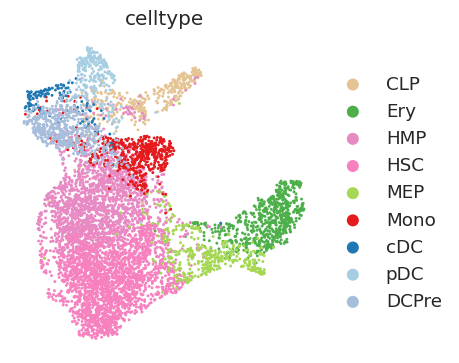

In [ ]:
# Plot cell-types for reference (ATAC)
sc.pl.scatter(atac_ad, basis='umap', color='celltype', frameon=False)

/usr/local/lib/python3.10/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/usr/local/lib/python3.10/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


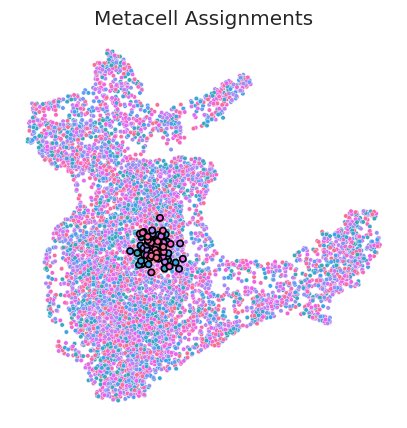

In [ ]:
SEACells.plot.plot_2D(atac_ad, key='X_umap', colour_metacells=True)

# Preparation step


In the first step, we derive summarized ATAC and RNA SEACell metacells Anndata objects. Both the input single-cell RNA and ATAC anndata objects should contain raw, unnormalized data. SEACell results on ATAC data will be used for the summarization

<b>Warning: </b> The ATAC and RNA single-cell Anndata objects should contain the same set of cells. Only the common cells will be used for downstream analyses.

In [ ]:
atac_meta_ad, rna_meta_ad = SEACells.genescores.prepare_multiome_anndata(atac_ad, rna_ad, SEACells_label='SEACell')

Generating Metacell matrices...
 ATAC


100%|██████████| 81/81 [00:07<00:00, 10.65it/s]
/usr/local/lib/python3.10/dist-packages/SEACells/genescores.py:77: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  atac_ad.var['log_n_counts'] = np.ravel(np.log10(atac_ad.X.sum(axis=0)))


 RNA


/usr/local/lib/python3.10/dist-packages/SEACells/genescores.py:58: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  rna_mod_ad.obs['temp'] = atac_mod_ad.obs[SEACells_label]
100%|██████████| 81/81 [00:00<00:00, 116.45it/s]


The preparation step will generate summarized anndata objects for RNA and ATAC

In [ ]:
#I save this
atac_meta_ad

AnnData object with n_obs × n_vars = 81 × 246113
    obs: 'n_counts'
    var: 'GC_bin', 'counts_bin', 'n_cells'
    uns: 'log1p'
    obsm: 'X_svd'
    layers: 'raw'

In [ ]:
atac_meta_ad.shape #Why was it 100 before??

(81, 246113)

In [ ]:
#I save this
rna_meta_ad

AnnData object with n_obs × n_vars = 81 × 12464
    obs: 'n_counts'
    uns: 'log1p'
    layers: 'raw'

# Gene-peak correlations

Using the paired multiome metacell data, the next step is to compute the correlation of gene expression and accessbility of peaks within the vicinity of the gene. 

Computation of gene peak correlations requires the following parameters :
1. GTF file with gene annotations. <b> Note: </b> Chromosome names should be numbered 1, 2 and the "chr" prefix will be added by SEACells 
2. Genomic span around genes to test the correlations 

Human GTF file is available at [https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/hg38.gtf](https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/hg38.gtf) and can be downloaded using:

In [ ]:
! wget https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/hg38.gtf -O data/hg38.gtf

--2023-05-04 01:42:53--  https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/hg38.gtf
Resolving dp-lab-data-public.s3.amazonaws.com (dp-lab-data-public.s3.amazonaws.com)... 52.216.131.27, 52.217.95.225, 3.5.25.121, ...
Connecting to dp-lab-data-public.s3.amazonaws.com (dp-lab-data-public.s3.amazonaws.com)|52.216.131.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1331958475 (1.2G) [binary/octet-stream]
Saving to: ‘data/hg38.gtf’

data/hg38.gtf       100%[===================>]   1.24G  40.1MB/s    in 38s     

2023-05-04 01:43:31 (33.9 MB/s) - ‘data/hg38.gtf’ saved [1331958475/1331958475]



In [ ]:
# In this example, we compute gene peak correlations for the first ten genes since (Okay I will have to run the whole thing..as I have changed the seacell assignment)
# this process is computationally intensive
gene_set = rna_meta_ad.var_names  
#gene_set = rna_meta_ad.var_names[6500:9000] 
#gene_set = rna_meta_ad.var_names[9000:] #Marek

gene_peak_cors = SEACells.genescores.get_gene_peak_correlations(atac_meta_ad, rna_meta_ad, 
                                           path_to_gtf='data/hg38.gtf', 
                                           span=100000, 
                                           n_jobs=1,
                                           gene_set=gene_set)

Loading transcripts per gene...


In [ ]:
import pickle
# Load data (deserialize) The dictionaries
with open('gene_peak_cors.pickle', 'rb') as handle:
    gene_peak_cors = pickle.load(handle)

In [ ]:
len(gene_peak_cors)

The result of this function is a `pandas.Series` object with one entry for each gene. Each entry is a `pandas.DataFrame` with the correlation of peak accessibility and gene expression and the p-value for significance of correlation using GC and accessiblity matched background sets

In [ ]:
gene_peak_cors['FAM41C'].head()

,cor,pval
chr1:816070-816570,-0.026061,0.674727
chr1:817092-817592,0.136620,0.234006
chr1:827266-827766,-0.031738,0.748975
chr1:838271-838771,-0.038642,0.744485
chr1:842638-843138,-0.181903,0.944502


If no peaks are present in the specified span of the gene, the entry in the dictionary contains a zero

In [ ]:
gene_peak_cors['LINC01128']

0

## Highly regulated genes

For downstream analyses, the full gene peak correlations results are available as a pickle file at [https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/cd34_multiome_gene_peak_cors.p](https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/cd34_multiome_gene_peak_cors.p) and can be downloaded using


In [ ]:
#! wget https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/cd34_multiome_gene_peak_cors.p -O data/cd34_multiome_gene_peak_cors.p

--2023-04-24 20:32:46--  https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/cd34_multiome_gene_peak_cors.p
Resolving dp-lab-data-public.s3.amazonaws.com (dp-lab-data-public.s3.amazonaws.com)... 54.231.172.33, 52.216.44.1, 3.5.28.118, ...
Connecting to dp-lab-data-public.s3.amazonaws.com (dp-lab-data-public.s3.amazonaws.com)|54.231.172.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20829641 (20M) [binary/octet-stream]
Saving to: ‘data/cd34_multiome_gene_peak_cors.p’

data/cd34_multiome_ 100%[===================>]  19.86M  55.7MB/s    in 0.4s    

2023-04-24 20:32:47 (55.7 MB/s) - ‘data/cd34_multiome_gene_peak_cors.p’ saved [20829641/20829641]



In [ ]:
#gene_peak_cors = pd.read_pickle('data/cd34_multiome_gene_peak_cors.p') 

In [ ]:
len(gene_peak_cors)

12464

Highly regulated genes i.e., genes that are correlated with multiple peaks can be identified using the `get_gene_peak_assocations` function. `get_gene_peak_assocations` returns the number of significantly peaks correlated with each gene

In [ ]:
peak_counts = SEACells.genescores.get_gene_peak_assocations(gene_peak_cors, 
                                                           pval_cutoff=1e-1,
                                                           cor_cutoff=0.1)

In [ ]:
peak_counts

In [ ]:
# Plot the distribution to identify genes with higher degree of regulation
plt.scatter(np.arange(len(peak_counts)), 
           np.sort(peak_counts), s=20)
sns.despine()
plt.xlabel('Gene rank')
plt.ylabel('No. of correlated peaks')

## Gene scores

Gene scores are computed as the weighted sum of the accessiblity of correlated peaks and can be computed using `get_gene_scores`. 

In [ ]:
gene_scores = SEACells.genescores.get_gene_scores(atac_meta_ad, 
                                                  gene_peak_cors,
                                                  pval_cutoff=1e-1,
                                                  cor_cutoff=0.1)

 65%|██████▍   | 8052/12464 [12:45<05:44, 12.82it/s]

In [ ]:
gene_scores.head()

,LINC01128,FAM41C,NOC2L,ISG15,AGRN,C1orf159,SDF4,B3GALT6,UBE2J2,SCNN1D,...,MPP1,F8,FUNDC2,CMC4,MTCP1,BRCC3,VBP1,RAB39B,CLIC2,TMLHE
cd34_multiome_rep1#TTGCAGCCAGGCGATA-1,0.0,0.570513,0.731350,0.739734,1.904926,2.233739,1.560649,0.972323,2.067873,0.270161,...,0.855887,0.288866,0.000000,0.164045,0.799325,0.339626,0.000000,1.593714,1.574285,0.429086
cd34_multiome_rep1#TACAGCTAGTAATCCA-1,0.0,0.953651,0.441605,1.037643,1.438327,1.209815,1.464998,1.308130,2.136856,0.624161,...,1.414793,0.421997,0.000000,0.115478,0.270583,0.423091,0.000000,1.886161,1.697975,0.305112
cd34_multiome_rep2#TAACCTAAGGATTGAG-1,0.0,1.290196,0.440713,1.163548,1.480968,1.309852,1.343252,0.737706,1.997828,0.606344,...,0.644719,0.000000,0.000000,0.000000,0.556236,0.172320,0.000000,1.803272,1.640732,0.322363
cd34_multiome_rep1#TAGCGGCTCATTATGG-1,0.0,0.348292,1.279213,0.730552,1.200275,1.297620,2.873269,2.518351,3.663783,1.788295,...,5.136016,1.501366,0.239975,0.625000,0.628632,0.288189,1.240271,2.157212,1.876490,0.599506
cd34_multiome_rep1#GCCCATAAGATGCCTG-1,0.0,1.141506,0.517398,0.811053,1.158877,1.332988,1.170214,1.342579,1.534297,0.513448,...,1.592785,0.433714,0.000000,0.167395,0.540766,0.240051,0.000000,1.912496,1.981116,0.539961


In [ ]:
print(gene_scores.columns)

print(gene_scores.iloc[1],gene_scores.iloc[2])

Index(['LINC01128', 'FAM41C', 'NOC2L', 'ISG15', 'AGRN', 'C1orf159', 'SDF4',
       'B3GALT6', 'UBE2J2', 'SCNN1D',
       ...
       'MPP1', 'F8', 'FUNDC2', 'CMC4', 'MTCP1', 'BRCC3', 'VBP1', 'RAB39B',
       'CLIC2', 'TMLHE'],
      dtype='object', length=12464)
LINC01128    0.000000
FAM41C       0.953651
NOC2L        0.441605
ISG15        1.037643
AGRN         1.438327
               ...   
BRCC3        0.423091
VBP1         0.000000
RAB39B       1.886161
CLIC2        1.697975
TMLHE        0.305112
Name: cd34_multiome_rep1#TACAGCTAGTAATCCA-1, Length: 12464, dtype: float64 LINC01128    0.000000
FAM41C       1.290196
NOC2L        0.440713
ISG15        1.163548
AGRN         1.480968
               ...   
BRCC3        0.172320
VBP1         0.000000
RAB39B       1.803272
CLIC2        1.640732
TMLHE        0.322363
Name: cd34_multiome_rep2#TAACCTAAGGATTGAG-1, Length: 12464, dtype: float64


`gene_scores` is a `pandas.DataFrame` with metacells as rows and genes as columns. This can be used for any downstream analysis such as clustering, visualization etc.

In [ ]:
#PICKLE CODE TO SAVE AND THEN LOAD ANY PYTHON OBJECT

import pickle

your_data = gene_scores

# Store data (serialize)
with open('gene_scores.pickle', 'wb') as handle:
    pickle.dump(your_data, handle, protocol=pickle.HIGHEST_PROTOCOL)


                                       LINC01128  FAM41C  NOC2L  ISG15  AGRN  \
cd34_multiome_rep1#TTGCAGCCAGGCGATA-1       True    True   True   True  True   
cd34_multiome_rep1#TACAGCTAGTAATCCA-1       True    True   True   True  True   
cd34_multiome_rep2#TAACCTAAGGATTGAG-1       True    True   True   True  True   
cd34_multiome_rep1#TAGCGGCTCATTATGG-1       True    True   True   True  True   
cd34_multiome_rep1#GCCCATAAGATGCCTG-1       True    True   True   True  True   
...                                          ...     ...    ...    ...   ...   
cd34_multiome_rep2#ACTTGTCGTAAGCTTG-1       True    True   True   True  True   
cd34_multiome_rep2#GAATTTGTCCTTCGTA-1       True    True   True   True  True   
cd34_multiome_rep1#GGCAAGCCATTCCTCG-1       True    True   True   True  True   
cd34_multiome_rep2#GGTCAAGCAGCACGAA-1       True    True   True   True  True   
cd34_multiome_rep2#TCTCAAGCAACACCTA-1       True    True   True   True  True   

                                       

In [ ]:
#Downloading files from google.cola to local drive...this can also be done to drive.
from google.colab import files
files.download('gene_scores.pickle')



FileNotFoundError: ignored

# Gene-accessibility

This section describes how to compute gene accessiblity metrics using SEACell metacells.

## Open peaks in metacells

The first step is to identify the subset of peaks that are open in each metacell. `determine_metacell_open_peaks` function can be used to determine this. 

By default, all peaks are tested to check if they are open or closed in every metacell. A subset of peaks can be specified using the `peak_set` parameter. 

This function also requires a low-dimensional embedding such as `X_svd`. We can summarize the SVD of single-cell ATAC for this analysis

In [ ]:
# Create a metacell anndata with raw counts
atac_meta_ad = SEACells.core.summarize_by_SEACell(atac_ad, SEACells_label='SEACell')
atac_meta_ad.obs['n_counts'] = np.ravel(atac_meta_ad.X.sum(axis=1))

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# We will reuse the atac_meta_ad computed above

# Add SVD summary to atac meta ad
seacell_label = 'SEACell'
sc_svd = pd.DataFrame(atac_ad.obsm['X_svd'], index=atac_ad.obs_names)
atac_meta_ad.obsm['X_svd'] = sc_svd.groupby(atac_ad.obs[seacell_label]).mean().loc[atac_meta_ad.obs_names, :]

In [ ]:
# Determine open peaks in each metacell
SEACells.accessibility.determine_metacell_open_peaks(atac_meta_ad, peak_set=None, low_dim_embedding='X_svd', pval_cutoff=1e-2,
                                  read_len=147, n_neighbors=3, n_jobs=1)
# This function will add 'OpenPeaks' to the Anndata layers and is a binary matrix 
# indicating whether the peak is open or closed in the metacell

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.24it/s]


In [ ]:
atac_meta_ad

AnnData object with n_obs × n_vars = 100 × 246113
    obs: 'n_counts'
    obsm: 'X_svd'
    layers: 'OpenPeaks'

## Gene accessibility metric

Open peaks are used to compute gene accessiblity metric which represents the fraction of correlated open peaks. 

<b>Warning: </b> This metric is only reliable if there are sufficient number of open peaks associated with each gene. 
It is recommended to be used for only genes with high regulation

Text(0, 0.5, 'No. of correlated peaks')

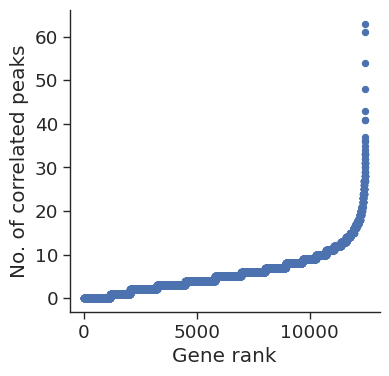

In [ ]:
# Use the highly regulated genes as the gene set of interest 
# Plot the distribution to identify genes with higher degree of regulation
plt.scatter(np.arange(len(peak_counts)), 
           np.sort(peak_counts), s=20)
sns.despine()
plt.xlabel('Gene rank')
plt.ylabel('No. of correlated peaks')

In [ ]:
# Select genes based on the elbow point
high_reg_genes = peak_counts.index[peak_counts > 9]

In [ ]:
# Compute gene accessibility
SEACells.accessibility.get_gene_accessibility(atac_meta_ad, gene_peak_cors, 
                                              gene_set=high_reg_genes, pval_cutoff=1e-1, cor_cutoff=0.1)
# p-value and corrrelation cutoffs are used for correlated peaks
# This function will add 'GeneAccessibility' to the Anndata `.obsm` field

100%|██████████████████████████████████████████████████████████████████████████████| 2198/2198 [00:03<00:00, 652.58it/s]


In [ ]:
atac_meta_ad.obsm['GeneAccessibility']

,UBE2J2,ACAP3,AURKAIP1,CCNL2,ATAD3A,GNB1,PRKCZ,FAAP20,SKI,PANK4,...,PRICKLE3,CCDC22,NHSL2,TSC22D3,TMEM164,AMMECR1,DOCK11,IDS,HCFC1,EMD
cd34_multiome_rep1#AAACAGCCACTCGCTC-1,0.636364,0.272727,0.533333,0.636364,0.7,0.692308,0.333333,0.6,0.354839,0.7,...,0.571429,0.692308,0.666667,0.6,0.538462,0.133333,0.363636,0.476190,0.7,0.363636
cd34_multiome_rep1#TTGCAGCCAGGCGATA-1,0.454545,0.454545,0.666667,0.636364,0.4,0.692308,0.333333,0.7,0.322581,0.4,...,0.357143,0.538462,0.500000,0.7,0.307692,0.000000,0.363636,0.285714,0.6,0.545455
cd34_multiome_rep1#TACAGCTAGTAATCCA-1,0.363636,0.545455,0.533333,0.818182,0.4,0.538462,0.428571,0.8,0.451613,0.7,...,0.428571,0.538462,0.583333,0.6,0.461538,0.000000,0.181818,0.428571,0.3,0.454545
cd34_multiome_rep2#TAACCTAAGGATTGAG-1,0.454545,0.454545,0.600000,0.727273,0.3,0.384615,0.523810,0.7,0.483871,0.4,...,0.500000,0.692308,0.666667,0.6,0.384615,0.066667,0.090909,0.523810,0.4,0.636364
cd34_multiome_rep1#TAGCGGCTCATTATGG-1,0.636364,0.454545,0.666667,0.727273,0.5,0.538462,0.428571,1.0,0.419355,0.7,...,0.857143,0.846154,0.416667,0.4,0.923077,0.866667,0.090909,0.142857,0.7,0.545455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cd34_multiome_rep2#ACTTGTCGTAAGCTTG-1,0.545455,0.454545,0.666667,0.727273,0.5,0.384615,0.333333,1.0,0.419355,1.0,...,0.785714,0.769231,0.250000,0.4,0.923077,0.933333,0.090909,0.238095,0.7,0.636364
cd34_multiome_rep2#GAATTTGTCCTTCGTA-1,0.818182,0.454545,0.666667,0.909091,0.6,0.615385,0.476190,0.7,0.580645,0.7,...,0.857143,0.769231,0.250000,0.6,0.692308,0.466667,0.272727,0.476190,0.7,0.545455
cd34_multiome_rep1#GGCAAGCCATTCCTCG-1,0.272727,0.454545,0.466667,0.454545,0.1,0.692308,0.285714,0.6,0.322581,0.5,...,0.285714,0.615385,0.500000,0.6,0.076923,0.066667,0.181818,0.380952,0.6,0.272727
cd34_multiome_rep2#GGTCAAGCAGCACGAA-1,0.181818,0.454545,0.400000,0.636364,0.5,0.692308,0.380952,0.6,0.483871,0.6,...,0.428571,0.615385,0.666667,0.5,0.384615,0.000000,0.363636,0.333333,0.5,0.272727


Gene accessiblity metrics can be used as inputs for downstream analyses.

### Visualization

In [ ]:
# First generate a summarized umap to visualize gene accessilibility
# We will use the RNA meta data to compare expression and accessibility 
rna_umap = pd.DataFrame(rna_ad.obsm['X_umap'], index=rna_ad.obs_names)
rna_meta_ad.obsm['X_umap'] = rna_umap.groupby(atac_ad.obs[seacell_label]).mean().loc[rna_meta_ad.obs_names, :].values


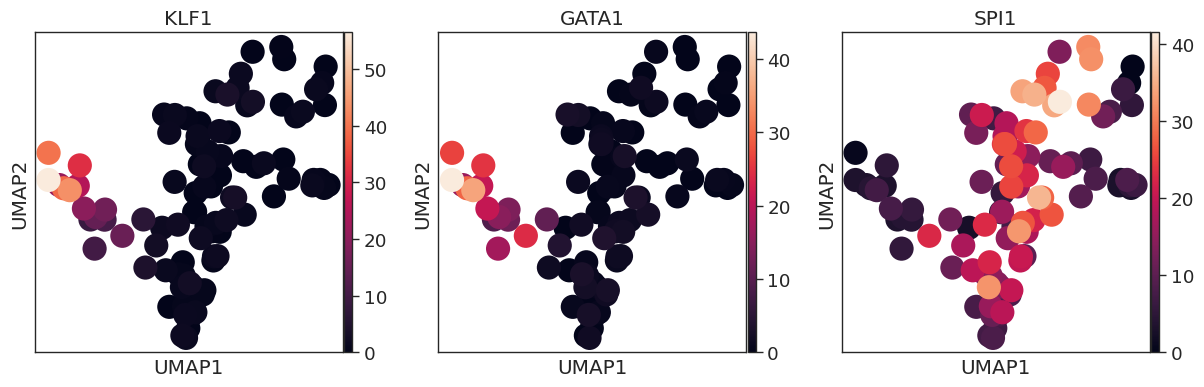

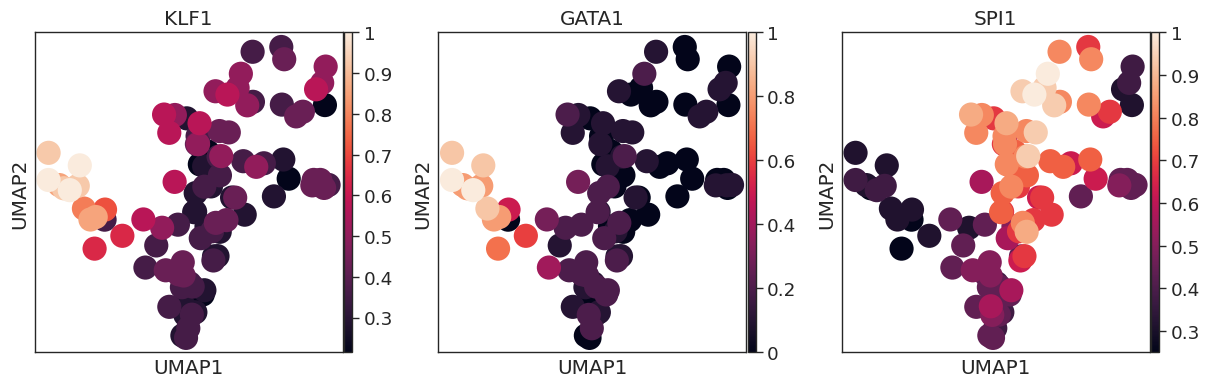

In [ ]:
genes = ['KLF1', 'GATA1', 'SPI1']
# Copy accessibility to RNA meta anndata
temp = rna_meta_ad[:, genes]
temp.layers['GeneAccessibility'] = atac_meta_ad[rna_meta_ad.obs_names].obsm['GeneAccessibility'][genes].values

# Plot expression
sc.pl.scatter(rna_meta_ad, basis='umap', color=genes)

# Plot accessibility
sc.pl.scatter(temp, basis='umap', color=genes, layers='GeneAccessibility')